In [1]:
!pip install dmslogo

from google.colab import output
output.clear()

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm
tqdm.pandas()

pd.set_option('display.max_columns', None)

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import dmslogo

No GPU available


In [3]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

class utils():
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor

    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT,
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

# class utils():
##     @staticmethod
#     def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
#         seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
#         for letterIdx, letter in enumerate(sequence_str):
#             seq_tensor[vocab_list.index(letter), letterIdx] = 1
#         seq_tensor = torch.Tensor(seq_tensor)
#         return seq_tensor

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

# Load CODA library and contributions

In [4]:
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)

row_filter_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
coda_library_df = boda2_df[row_filter_1 | (boda2_df['method'] == 'fsp') ].reset_index(drop=True)

In [5]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')

cell_types = ['K562', 'HepG2', 'SKNSH']

contributions_dicts = {}
for cell_type in cell_types:
  contributions_dicts[cell_type] = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_contributions_{cell_type}.pt')

all_contributions = torch.stack([contributions_dicts[cell_type]['contributions'] for cell_type in cell_types], dim=0)
all_hyp_contributions = torch.stack([contributions_dicts[cell_type]['hyp_contributions'] for cell_type in cell_types], dim=0)

cell_colors = ['#00A79D', '#FBB040', '#ED1C24']

# Modisco motif hypothetical scores

In [6]:
pos_pattern_dict = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/merged_pos_patterns.pt')
neg_pattern_dict = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/merged_neg_patterns.pt')

In [7]:
chop_pos_dict = {#'0': [6, 24],
                 '0_E': [6, 14],
                 '1': [11, 20],
                 '2': [16, 26],
                 '3': [7, 23],
                 '4': [9, 21],
                 '5': [9, 17],
                 '6': [10, 21],
                 '7': [14, 24],
                 #'8': [9, 24],         #5 & 31
                 #'9_full': [7, 23],    #left side not relevant?
                 '10_G': [20, 28],
                 #'11_A': [17, 25],     #use 23_A
                 '12': [8, 25],
                 '14': [10, 23],
                 '15': [8, 16],
                 '16': [7, 25],         #change stop from 22 to 25? <---
                 '21': [8, 21],
                 '22': [5, 16],
                 '23_A': [17, 25],
                 #'25_B': [6, 16],       #similar to 23_A
                 '26': [13, 22],
                 '27_C': [11, 17],
                 #'27_full': [6, 17],   #left side 23_A?
                 #'28_A': [19, 27],     #use 23_A
                 '30': [6, 17],
                 '31': [11, 21],        #change start from 12 to 11? <---
                 '32_H': [6, 15],
                 '33': [12, 22],
                 '34': [6, 23],
                 #'36_C': [8, 17],
                 #'36_full': [8, 25],        #2 & 27 % 23_A
                 '39': [9, 20],
                 '44': [8, 19],
                 '46': [12, 25],
                 #'47_D': [21, 29],          #similar to 1?
                 #'50_half': [9, 15],        #similar to 30?
                 #'50_full': [2, 15],        #two 30s fwd + rev?
                 '51_I': [2, 11],             #Needs rescaling
                 '57_F': [6, 17],
                 }

chop_neg_dict = {'0': [17, 26],
                 '5': [16, 26],
                 '6': [10, 19],
                 }

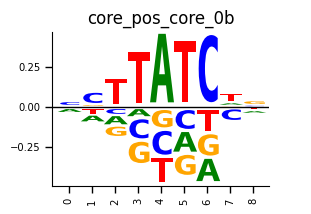

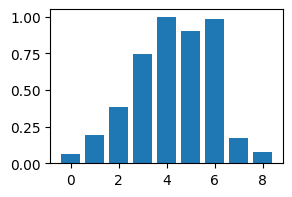

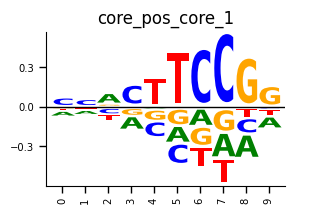

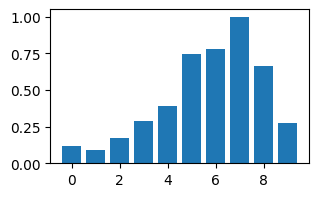

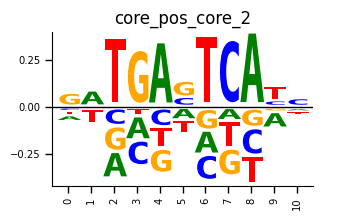

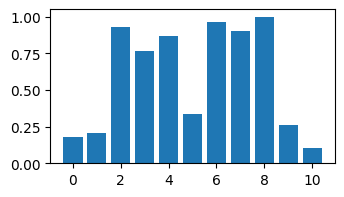

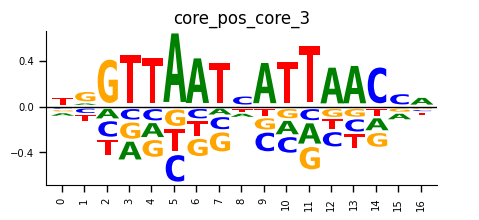

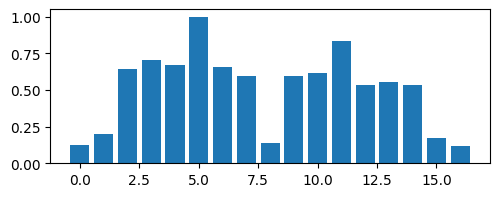

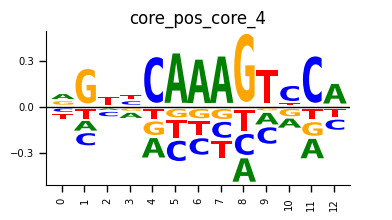

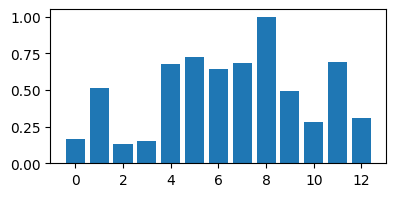

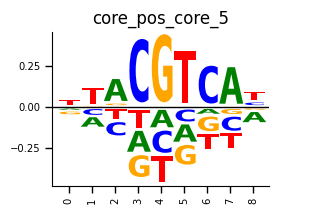

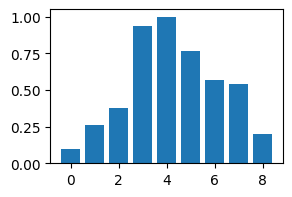

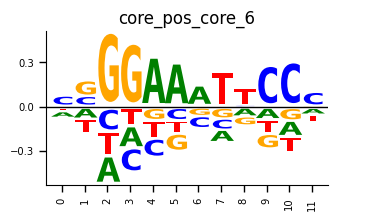

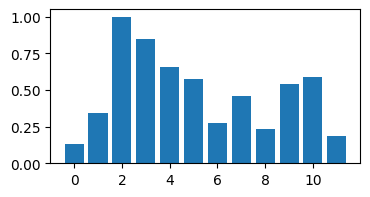

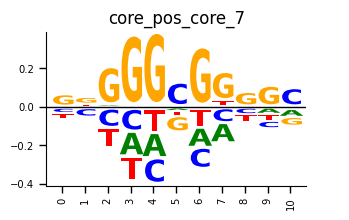

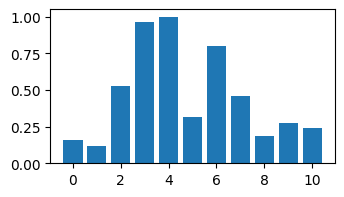

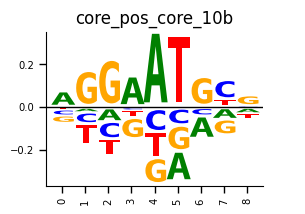

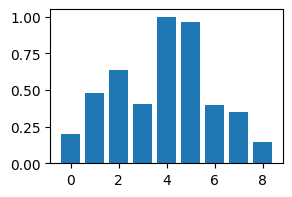

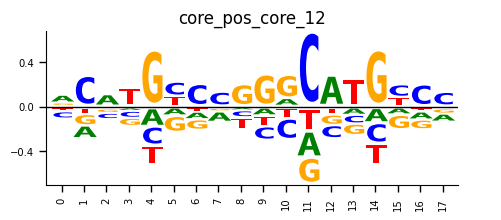

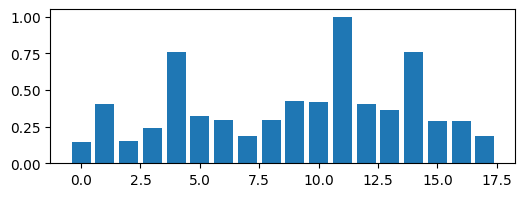

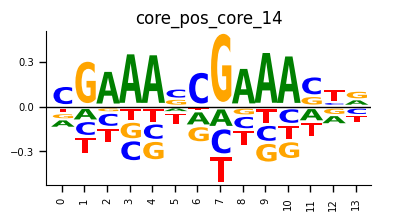

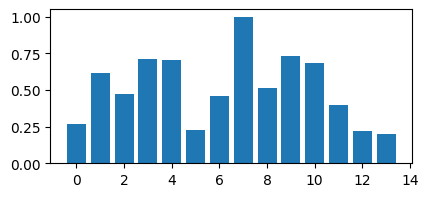

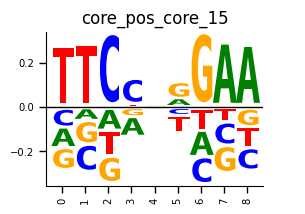

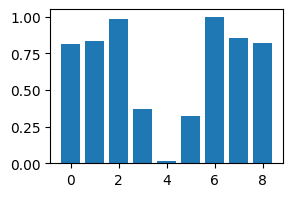

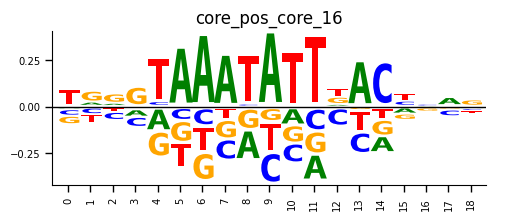

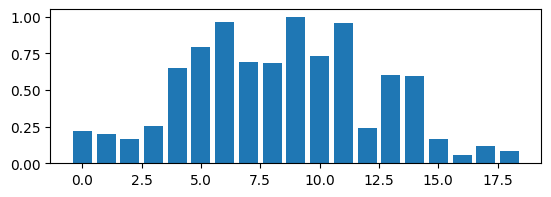

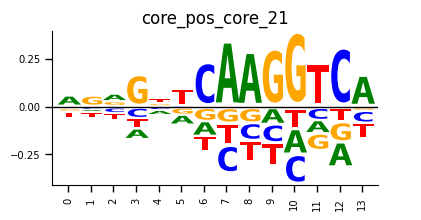

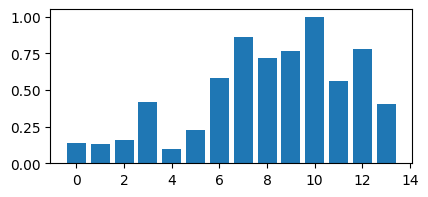

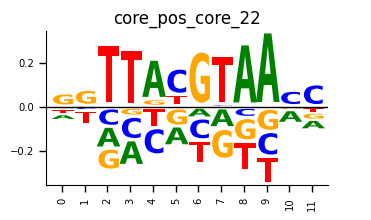

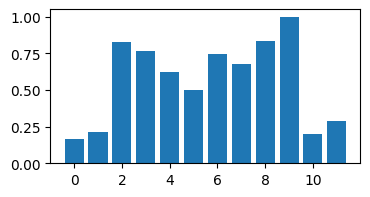

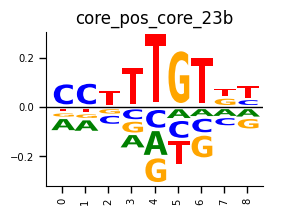

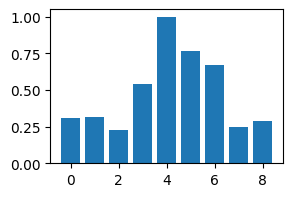

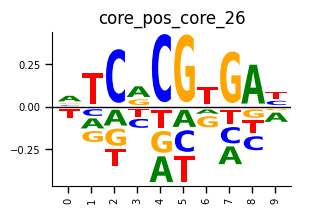

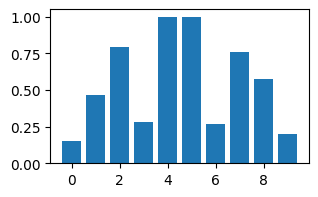

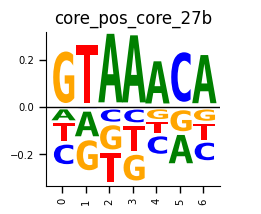

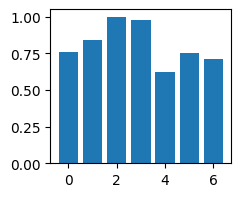

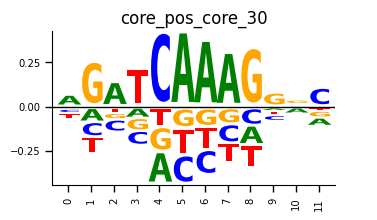

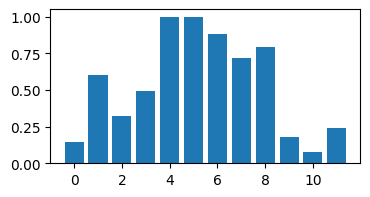

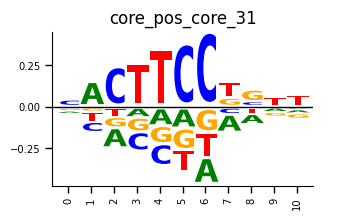

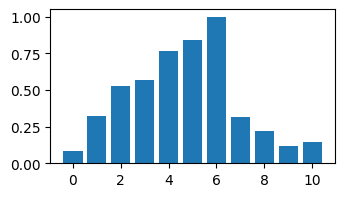

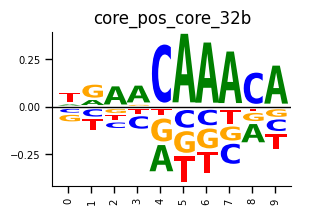

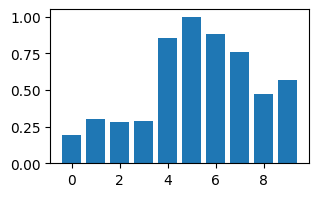

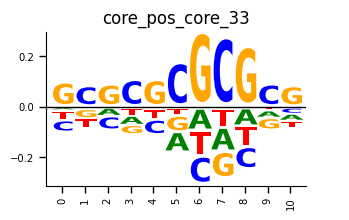

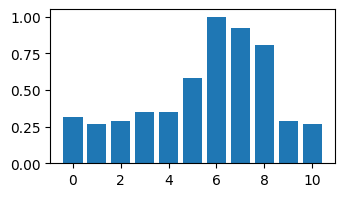

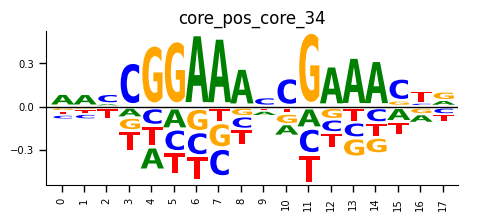

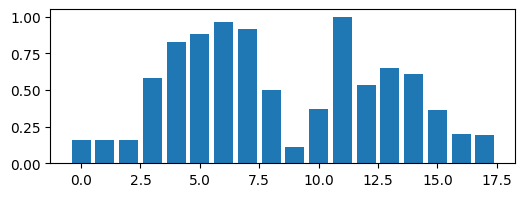

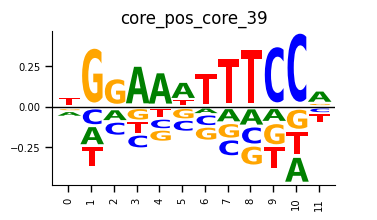

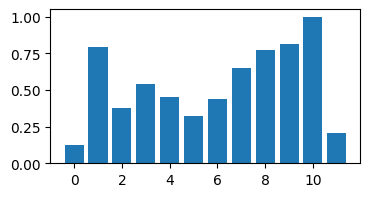

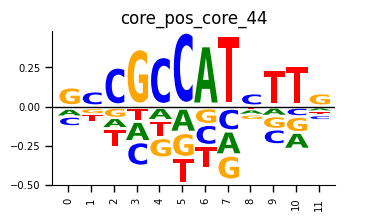

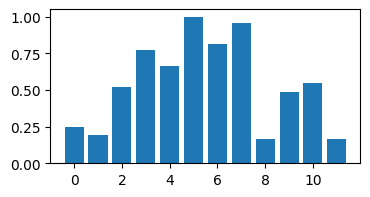

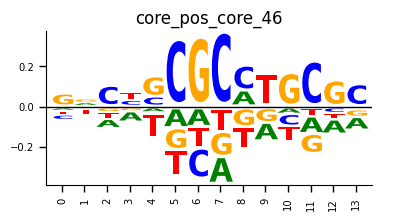

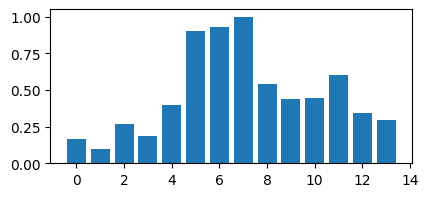

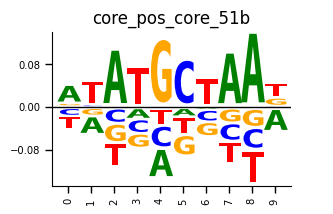

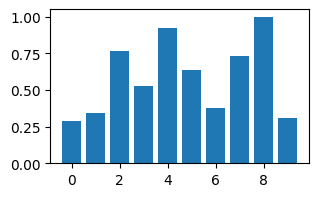

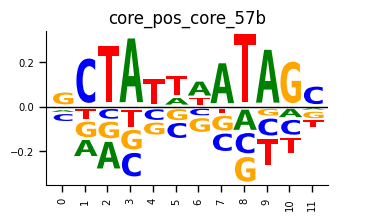

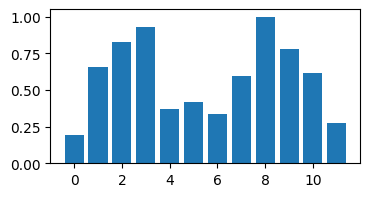

In [8]:
loaded_patterns = pos_pattern_dict['merged_pattern_hypscores']

pos_core_hyp_scores = []
pos_core_names = []
for core_key, core_start_stop in chop_pos_dict.items():
    pattern_idx = int(core_key.split(sep='_')[0])
    core_start = core_start_stop[0] - 1
    core_stop = core_start_stop[1]
    if "_" in core_key:
        core_name = f'pos_core_{pattern_idx}b'
    else:
        core_name = f'pos_core_{pattern_idx}'
    pattern_scores = loaded_patterns[pattern_idx, ...]
    pattern_scores = pattern_scores[core_start:core_stop, :]

    pos_core_hyp_scores.append(torch.Tensor(pattern_scores).T)
    pos_core_names.append(core_name)

    plot_tensor = torch.Tensor(pattern_scores).T
    y_max = plot_tensor.max()
    matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                        axisfontscale=0.6, heightscale=0.8)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'core_{core_name}')
    plt.show()

    plt.figure(figsize=(pattern_scores.shape[0]/3, 2))
    heigths = np.abs(pattern_scores).sum(axis=1)
    heigths = heigths / heigths.max()
    plt.bar(x=range(pattern_scores.shape[0]), height=heigths)
    plt.show()

    print()

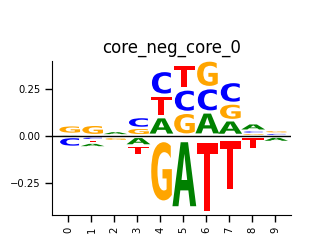

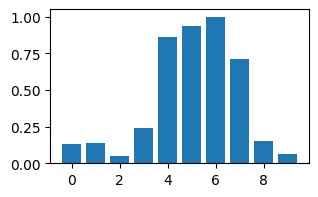

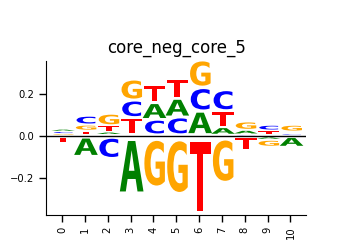

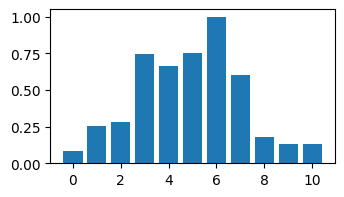

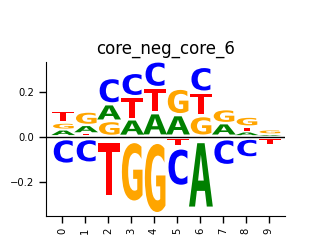

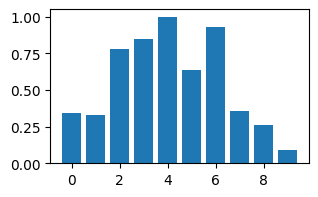

In [9]:
loaded_patterns = np.stack(neg_pattern_dict['merged_pattern_hypscores'], axis=0)

neg_core_hyp_scores = []
neg_core_names = []
for core_key, core_start_stop in chop_neg_dict.items():
    pattern_idx = int(core_key.split(sep='_')[0])
    core_start = core_start_stop[0] - 1
    core_stop = core_start_stop[1]
    if "_" in core_key:
        core_name = f'neg_core_{pattern_idx}b'
    else:
        core_name = f'neg_core_{pattern_idx}'
    pattern_scores = loaded_patterns[pattern_idx, ...]
    pattern_scores = pattern_scores[core_start:core_stop, :]

    neg_core_hyp_scores.append(torch.Tensor(pattern_scores).T)
    neg_core_names.append(core_name)

    plot_tensor = torch.Tensor(pattern_scores).T
    y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
    matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                        axisfontscale=0.6, heightscale=0.8)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'core_{core_name}')
    plt.show()

    plt.figure(figsize=(pattern_scores.shape[0]/3, 2))
    heigths = np.abs(pattern_scores).sum(axis=1)
    heigths = heigths / heigths.max()
    plt.bar(x=range(pattern_scores.shape[0]), height=heigths)
    plt.show()

    print()

# Contribution-based STREME motif hypothetical scores

In [10]:
boda2_streme_tfs = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/STREME_min8_TFs_merge.txt', sep=" ", low_memory=False)

df_array_columns = ['pfm', 'pwm', 'pwm_rc', 'pssm', 'pssm_rc', 'icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
for df_array_column in tqdm(df_array_columns):
    boda2_streme_tfs[df_array_column] = boda2_streme_tfs.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)

  0%|          | 0/9 [00:00<?, ?it/s]

In [13]:
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/fimo_min8.tsv', sep='\t')
fimo_df = fimo_df[:-3].reset_index(drop=True)

fimo_df['start'] = fimo_df['start'].to_numpy() - 1 #np.maximum(0, fimo_df['start'].to_numpy() - 1)
fimo_df['stop'] = fimo_df['stop'].to_numpy() + 0 #np.minimum(200, fimo_df['stop'].to_numpy() + 0)
fimo_df['start'] = fimo_df['start'].astype(int)
fimo_df['stop'] = fimo_df['stop'].astype(int)

fimo_df = fimo_df[fimo_df['sequence_name'].isin(coda_library_df['ID'].to_list())].reset_index(drop=True)

In [16]:
motif_list = boda2_streme_tfs['name'].tolist()

id2idx_dict = dict(zip(coda_library_df['ID'], coda_library_df.index))

all_fwd_motif_contributions = []
all_rev_motif_contributions = []

all_fwd_motif_hyp_contributions = []
all_rev_motif_hyp_contributions = []
for motif_id in tqdm(motif_list):
    motif_fimo_df = fimo_df[fimo_df['motif_id'] == motif_id]
    #Forward hits
    strand_motif_fimo_df = motif_fimo_df[motif_fimo_df['strand'] == '+'].reset_index(drop=True)
    motif_starts = strand_motif_fimo_df['start'].tolist()
    motif_stops = strand_motif_fimo_df['stop'].tolist()
    motif_seq_ids = strand_motif_fimo_df['sequence_name'].tolist()
    seq_idxs = [id2idx_dict[id] for id in motif_seq_ids]
    motif_contributions = []
    motif_hyp_contributions = []
    iterator = zip(seq_idxs, zip(motif_starts, motif_stops))
    for seq_idx, (start, stop) in iterator:
        motif_contributions.append(all_contributions[:, seq_idx, ..., start:stop])
        motif_hyp_contributions.append(all_hyp_contributions[:, seq_idx, ..., start:stop])
    all_fwd_motif_contributions.append(torch.stack(motif_contributions).mean(dim=0))
    all_fwd_motif_hyp_contributions.append(torch.stack(motif_hyp_contributions).mean(dim=0))

    #Reverse complement hits
    strand_motif_fimo_df = motif_fimo_df[motif_fimo_df['strand'] == '-'].reset_index(drop=True)
    motif_starts = strand_motif_fimo_df['start'].tolist()
    motif_stops = strand_motif_fimo_df['stop'].tolist()
    motif_seq_ids = strand_motif_fimo_df['sequence_name'].tolist()
    seq_idxs = [id2idx_dict[id] for id in motif_seq_ids]
    motif_contributions = []
    motif_hyp_contributions = []
    iterator = zip(seq_idxs, zip(motif_starts, motif_stops))
    for seq_idx, (start, stop) in iterator:
        motif_contributions.append(all_contributions[:, seq_idx, ..., start:stop])
        motif_hyp_contributions.append(all_hyp_contributions[:, seq_idx, ..., start:stop])
    all_rev_motif_contributions.append(torch.stack(motif_contributions).mean(dim=0))
    all_rev_motif_hyp_contributions.append(torch.stack(motif_hyp_contributions).mean(dim=0))

  0%|          | 0/82 [00:00<?, ?it/s]

In [17]:
consensus_onehots = [utils.dna2tensor(seq) for seq in boda2_streme_tfs['consensus'].tolist()]

all_streme_hyp_scores = []
for i in range(82):
    motif_name = boda2_streme_tfs.iloc[i]['ultimate_id']

    fwd_motif_hyp_contributions = all_fwd_motif_hyp_contributions[i]
    rev_motif_hyp_contributions = all_rev_motif_hyp_contributions[i]
    motif_hyp_contributions = fwd_motif_hyp_contributions + utils.reverse_complement_onehot(rev_motif_hyp_contributions)

    consensus_contributions = motif_hyp_contributions * consensus_onehots[i].reshape(1, 4, -1)
    preferred_cell_idx = consensus_contributions.sum(dim=[1,2]).abs().argmax().item()

    all_streme_hyp_scores.append(motif_hyp_contributions[preferred_cell_idx,...])

[2 3 0]


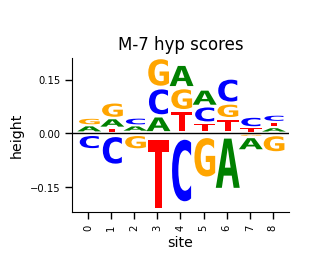

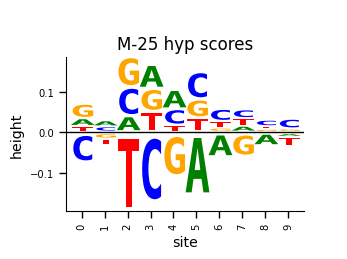

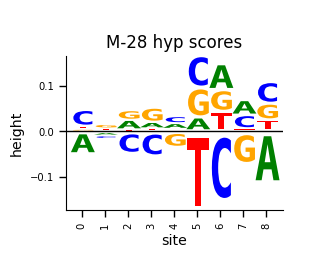

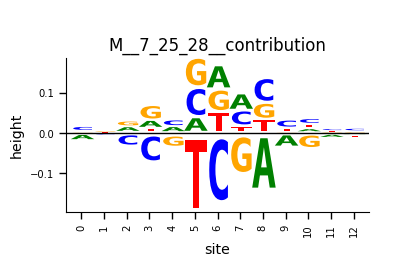


[0 1 3]


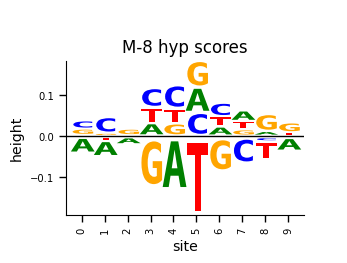

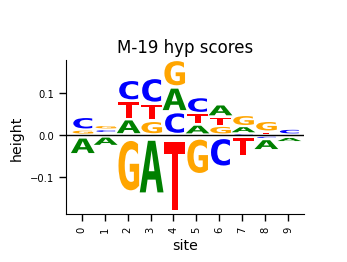

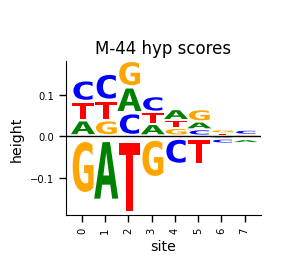

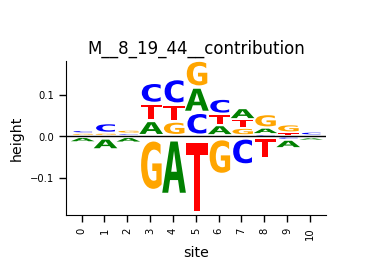


[0 0 2]


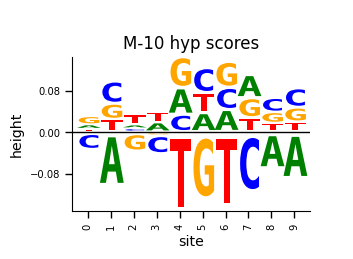

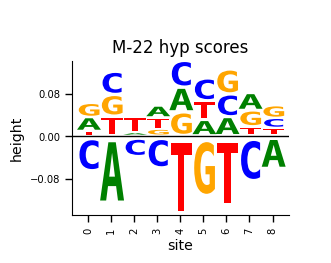

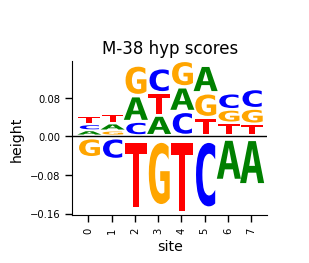

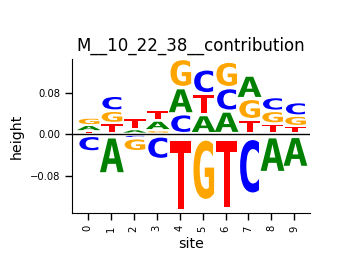


[0]


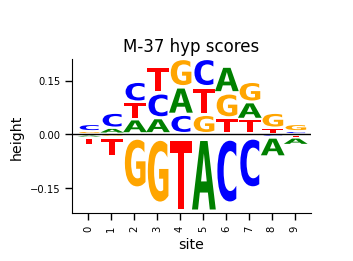

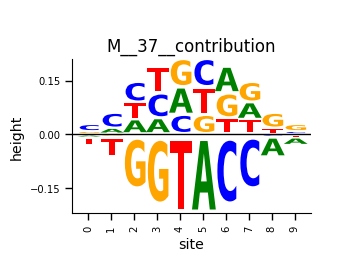


[0]


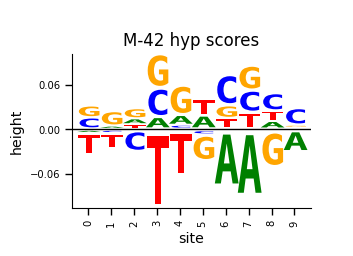

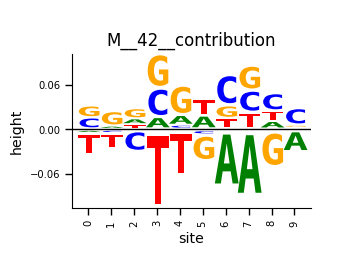

In [18]:
clustered_idxs = [[7, 25, 28], [8, 19, 44], [10, 22, 38], [37], [42]]
cluster_offsets = [[0, 1, -2], [0, 1, 3], [0, 0, 2], [0], [0]]

all_cluster_hyp_contributions = []
cluster_names = []
for idx_cluster, offset_cluster in zip(clustered_idxs, cluster_offsets):
    offset_cluster = np.array(offset_cluster)
    offset_cluster = offset_cluster - offset_cluster.min()
    print(offset_cluster)
    for idx in idx_cluster:
        plot_tensor = all_streme_hyp_scores[idx - 1]
        y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
        matrix_to_dms(plot_tensor, y_max=y_max)
        plt.title(f'M-{idx} hyp scores')
        plt.show()
    cluster_motifs = []
    for idx, offset in zip(idx_cluster, offset_cluster):
        plot_tensor = torch.cat([torch.zeros((4, offset)), all_streme_hyp_scores[idx - 1]], dim=-1)
        cluster_motifs.append(plot_tensor)
    motif_lengths = [motif.shape[-1] for motif in cluster_motifs]
    max_length = max(motif_lengths)
    cluster_motifs = [torch.cat([motif, torch.zeros((4, max_length - motif.shape[-1]))], dim=-1) for motif in cluster_motifs]
    cluster_motifs = torch.stack(cluster_motifs, dim=0).mean(dim=0)

    all_cluster_hyp_contributions.append(cluster_motifs)

    # mask = (cluster_motifs!=0)
    # cluster_ppm = (cluster_motifs * mask).sum(dim=0)/mask.sum(dim=0)
    # cluster_icm = ppm_to_IC(cluster_ppm)

    # all_cluster_ppms.append(cluster_ppm)
    # all_cluster_icms.append(cluster_icm)

    plot_tensor = cluster_motifs.clone()
    y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
    matrix_to_dms(plot_tensor, y_max=y_max)
    title = f'M__' + "_".join(map(str, idx_cluster)) + '__contribution'
    plt.title(title)
    plt.show()
    cluster_names.append(title)
    print()

streme_core_names = []
for name in cluster_names:
    idxs = name.split('__')[1]
    streme_core_names.append(f'streme_cluster__{idxs}')

In [19]:
all_motif_hyp_scores = pos_core_hyp_scores + neg_core_hyp_scores + all_cluster_hyp_contributions
motif_names = pos_core_names + neg_core_names + streme_core_names

#all_motif_list = [ppm.numpy() for ppm in all_motif_hyp_scores]

save_dict = dict(zip(motif_names, all_motif_hyp_scores))
#torch.save(save_dict, "/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_hyp_scores.pt")

# Motif instances with hypothetical-score motifs

In [6]:
custom_motif_names = ['GATA3', 'ELK4', 'FOSB::JUNB', 'HNF1B', 'HNF4A', 'CREB1', 'RELA', 'SP1', 'TEAD4',
                      'TP53', 'IRF4', 'STAT1', 'FOXB1', 'NR5A1', 'DBP', 'SOX4', 'SREBF2', 'FOXI1',
                      'TCF7L1', 'EHF', 'FOXJ2', '*NRF1', 'IRF3', 'NFATC2 x2', 'TYY1', 'NRF1', 'POU3F4', 'MEF2B',
                      'GFI1B', 'ID4', '*NFIB', 'STREME_1', 'STREME_2', 'MEIS2', 'STREME_4', '*HSF1'
                      ]

In [7]:
signed_contributions = torch.sign(all_contributions)
signed_hyp_contributions = torch.sign(all_hyp_contributions)

In [8]:
motif_hyp_scores_dict = torch.load("/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_hyp_scores.pt")

motif_ids = list(motif_hyp_scores_dict.keys())
fwd_motif_hyp_scores = list(motif_hyp_scores_dict.values())
rev_motif_hyp_scores = [utils.reverse_complement_onehot(motif) for motif in fwd_motif_hyp_scores]

In [ ]:
threshold = 0.1

moitf_idx = 2

unfiltered_motif_scores = fwd_motif_hyp_scores[moitf_idx]

plt.figure(figsize=(unfiltered_motif_scores.shape[1]/3, 2))
heigths = unfiltered_motif_scores.abs().sum(dim=0)
heigths = heigths / heigths.max()
plt.bar(x=range(unfiltered_motif_scores.shape[1]), height=heigths)
plt.hlines(threshold, -0.5, unfiltered_motif_scores.shape[1] - 0.5, linestyles='dashed', zorder=0)
plt.show()

threshold_filter = (heigths > threshold)

fwd_hyp_scores = unfiltered_motif_scores * threshold_filter
rev_hyp_scores = utils.reverse_complement_onehot(fwd_hyp_scores)

filters = torch.sign(torch.stack([fwd_hyp_scores, rev_hyp_scores]))

plot_tensor = fwd_hyp_scores.clone()
y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
matrix_to_dms(plot_tensor, y_max=y_max)
plt.show()

plot_tensor = rev_hyp_scores.clone()
y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
matrix_to_dms(plot_tensor, y_max=y_max)
plt.show()

In [146]:
position_thershold = 0.2

fwd_position_filter = (position_importances[0] > position_thershold)
rev_position_filter = (position_importances[1] > position_thershold)

filters[0, ...] = filters[0, ...] * (fwd_position_filter)
filters[1, ...] = filters[1, ...] * (rev_position_filter)

In [147]:

fwd_position_filter.sum().item()


10

In [151]:
custom_motif_names.index('GFI1B')

28

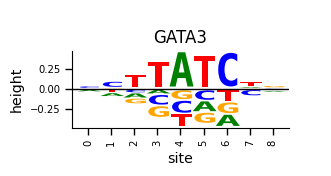

41315 matches in K562 (filtered from 297404 candidates)
98 matches in HepG2 (filtered from 283347 candidates)
18 matches in SKNSH (filtered from 282233 candidates)



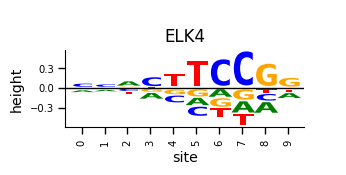

2518 matches in K562 (filtered from 140476 candidates)
2914 matches in HepG2 (filtered from 181596 candidates)
3560 matches in SKNSH (filtered from 203570 candidates)



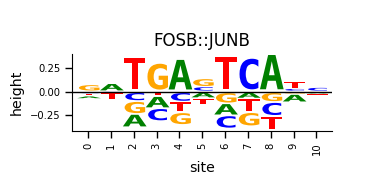

4393 matches in K562 (filtered from 35792 candidates)
5764 matches in HepG2 (filtered from 53292 candidates)
5178 matches in SKNSH (filtered from 63754 candidates)



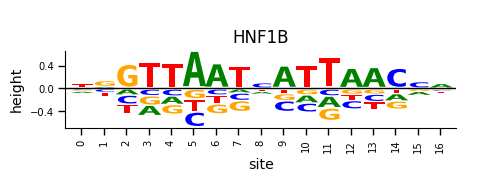

0 matches in K562 (filtered from 1263 candidates)
5173 matches in HepG2 (filtered from 9710 candidates)
0 matches in SKNSH (filtered from 3025 candidates)



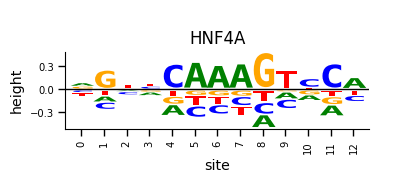

0 matches in K562 (filtered from 11292 candidates)
3322 matches in HepG2 (filtered from 18962 candidates)
0 matches in SKNSH (filtered from 14984 candidates)



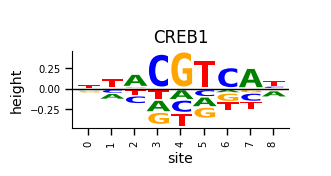

5722 matches in K562 (filtered from 202977 candidates)
5256 matches in HepG2 (filtered from 239535 candidates)
5731 matches in SKNSH (filtered from 255324 candidates)



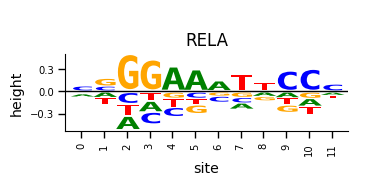

9 matches in K562 (filtered from 18926 candidates)
625 matches in HepG2 (filtered from 28881 candidates)
2274 matches in SKNSH (filtered from 23837 candidates)



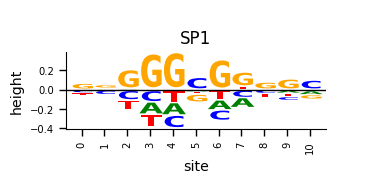

2387 matches in K562 (filtered from 51468 candidates)
2124 matches in HepG2 (filtered from 61759 candidates)
1743 matches in SKNSH (filtered from 69261 candidates)



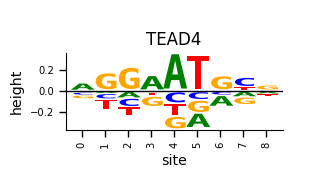

3 matches in K562 (filtered from 103183 candidates)
1061 matches in HepG2 (filtered from 125151 candidates)
3187 matches in SKNSH (filtered from 110950 candidates)



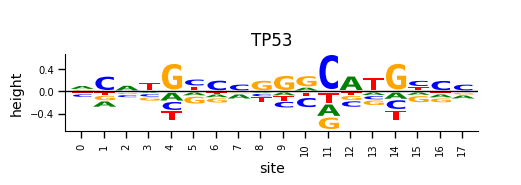

0 matches in K562 (filtered from 915 candidates)
0 matches in HepG2 (filtered from 1731 candidates)
0 matches in SKNSH (filtered from 2219 candidates)



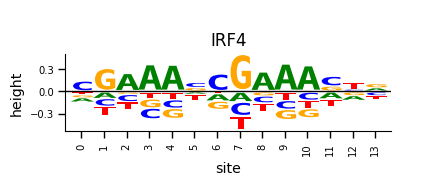

70 matches in K562 (filtered from 4051 candidates)
125 matches in HepG2 (filtered from 4771 candidates)
183 matches in SKNSH (filtered from 6081 candidates)



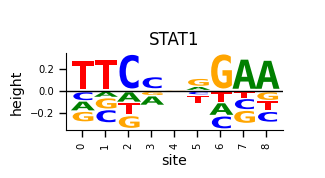

8371 matches in K562 (filtered from 146058 candidates)
200 matches in HepG2 (filtered from 183334 candidates)
233 matches in SKNSH (filtered from 164356 candidates)



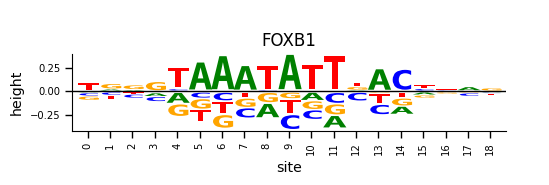

0 matches in K562 (filtered from 264 candidates)
189 matches in HepG2 (filtered from 661 candidates)
0 matches in SKNSH (filtered from 358 candidates)



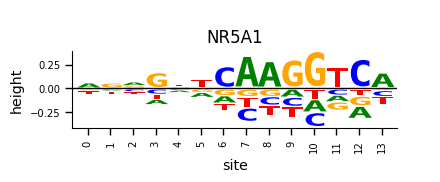

4 matches in K562 (filtered from 13927 candidates)
327 matches in HepG2 (filtered from 18191 candidates)
0 matches in SKNSH (filtered from 21541 candidates)



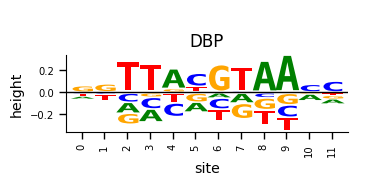

16 matches in K562 (filtered from 10742 candidates)
855 matches in HepG2 (filtered from 13705 candidates)
25 matches in SKNSH (filtered from 13112 candidates)



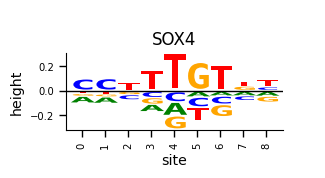

16 matches in K562 (filtered from 89925 candidates)
1603 matches in HepG2 (filtered from 108430 candidates)
270 matches in SKNSH (filtered from 109175 candidates)



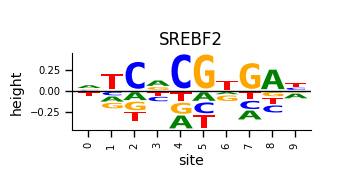

351 matches in K562 (filtered from 61099 candidates)
394 matches in HepG2 (filtered from 70722 candidates)
568 matches in SKNSH (filtered from 70370 candidates)



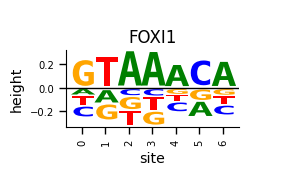

1001 matches in K562 (filtered from 324313 candidates)
4671 matches in HepG2 (filtered from 352323 candidates)
86 matches in SKNSH (filtered from 428352 candidates)



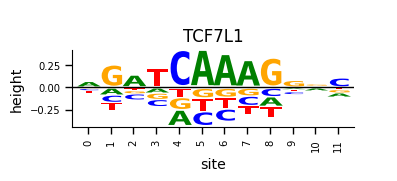

0 matches in K562 (filtered from 49865 candidates)
1114 matches in HepG2 (filtered from 82551 candidates)
0 matches in SKNSH (filtered from 88124 candidates)



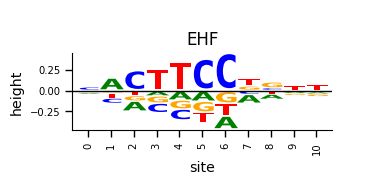

1485 matches in K562 (filtered from 50099 candidates)
1037 matches in HepG2 (filtered from 65587 candidates)
1846 matches in SKNSH (filtered from 64939 candidates)



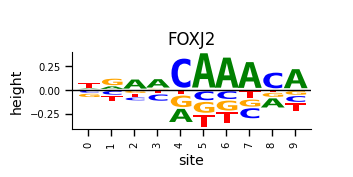

59 matches in K562 (filtered from 31591 candidates)
1618 matches in HepG2 (filtered from 38582 candidates)
20 matches in SKNSH (filtered from 40698 candidates)



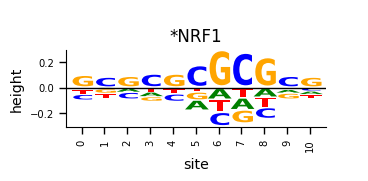

121 matches in K562 (filtered from 95307 candidates)
64 matches in HepG2 (filtered from 128456 candidates)
40 matches in SKNSH (filtered from 125425 candidates)



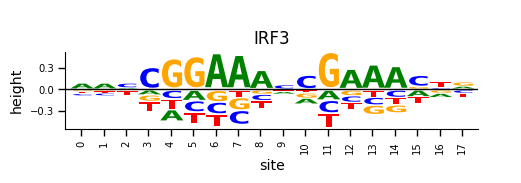

13 matches in K562 (filtered from 491 candidates)
21 matches in HepG2 (filtered from 614 candidates)
30 matches in SKNSH (filtered from 877 candidates)



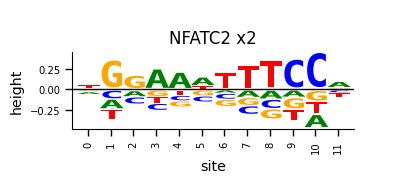

6 matches in K562 (filtered from 23796 candidates)
103 matches in HepG2 (filtered from 30949 candidates)
53 matches in SKNSH (filtered from 27576 candidates)



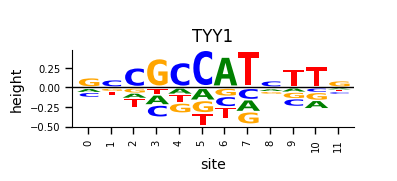

30 matches in K562 (filtered from 34870 candidates)
20 matches in HepG2 (filtered from 60184 candidates)
67 matches in SKNSH (filtered from 63713 candidates)



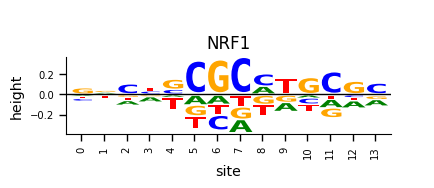

12 matches in K562 (filtered from 26164 candidates)
26 matches in HepG2 (filtered from 32627 candidates)
19 matches in SKNSH (filtered from 29790 candidates)



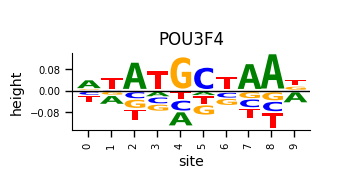

218 matches in K562 (filtered from 47347 candidates)
42 matches in HepG2 (filtered from 46940 candidates)
3 matches in SKNSH (filtered from 45988 candidates)



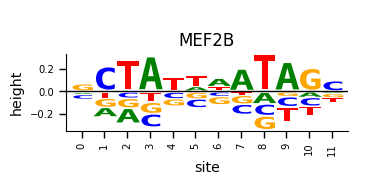

78 matches in K562 (filtered from 14156 candidates)
21 matches in HepG2 (filtered from 28432 candidates)
353 matches in SKNSH (filtered from 30292 candidates)



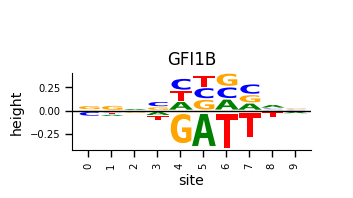

24174 matches in K562 (filtered from 278157 candidates)
4883 matches in HepG2 (filtered from 244894 candidates)
2893 matches in SKNSH (filtered from 225842 candidates)



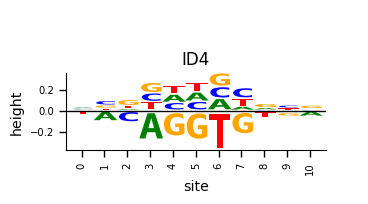

2771 matches in K562 (filtered from 117413 candidates)
3622 matches in HepG2 (filtered from 104377 candidates)
5848 matches in SKNSH (filtered from 95501 candidates)



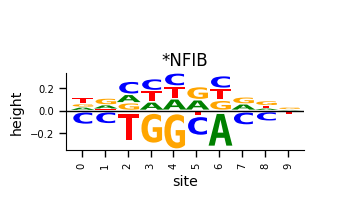

6901 matches in K562 (filtered from 134445 candidates)
5660 matches in HepG2 (filtered from 141794 candidates)
3405 matches in SKNSH (filtered from 129754 candidates)



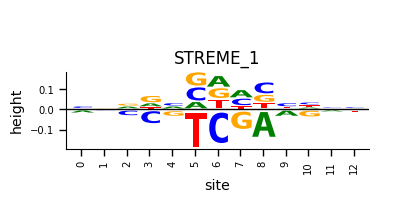

3288 matches in K562 (filtered from 128688 candidates)
6900 matches in HepG2 (filtered from 143573 candidates)
4224 matches in SKNSH (filtered from 176563 candidates)



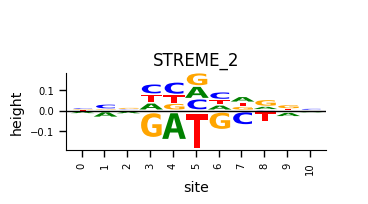

7629 matches in K562 (filtered from 255004 candidates)
14783 matches in HepG2 (filtered from 226926 candidates)
4548 matches in SKNSH (filtered from 183624 candidates)



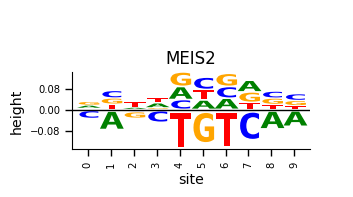

1823 matches in K562 (filtered from 103983 candidates)
8717 matches in HepG2 (filtered from 124762 candidates)
10602 matches in SKNSH (filtered from 82987 candidates)



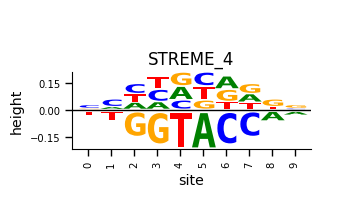

4134 matches in K562 (filtered from 57344 candidates)
4152 matches in HepG2 (filtered from 51356 candidates)
3554 matches in SKNSH (filtered from 69296 candidates)



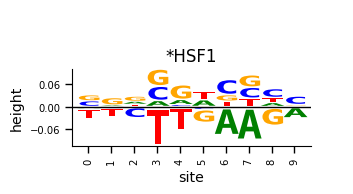

618 matches in K562 (filtered from 57041 candidates)
3198 matches in HepG2 (filtered from 91478 candidates)
1148 matches in SKNSH (filtered from 106287 candidates)



In [156]:
content_threshold = 0.6
position_thershold = 0.1

all_motif_passing_seqs = []
all_motif_passing_rc_flags = []
all_motif_passing_starts = []
all_motif_passing_ends = []
for moitf_idx, motif_name in enumerate(custom_motif_names):
    if moitf_idx >= 28:
        motif_orientation = -1
    else:
        motif_orientation = 1
    fwd_hyp_scores = fwd_motif_hyp_scores[moitf_idx]
    rev_hyp_scores = utils.reverse_complement_onehot(fwd_hyp_scores)
    motif_length = fwd_hyp_scores.shape[1]
    position_importances = []
    for scores in [fwd_hyp_scores, rev_hyp_scores]:
        heigths = scores.abs().sum(dim=0)
        position_importances.append(heigths / heigths.max())

    plot_tensor = fwd_hyp_scores.clone()
    y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
    matrix_to_dms(plot_tensor, y_max=y_max, heightscale=0.4)
    plt.title(motif_name)
    plt.show()

    # plot_tensor = rev_hyp_scores.clone()
    # y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
    # matrix_to_dms(plot_tensor, y_max=y_max)
    # plt.show()

    filters = torch.sign(torch.stack([fwd_hyp_scores, rev_hyp_scores]))

    fwd_position_filter = (position_importances[0] > position_thershold)
    rev_position_filter = (position_importances[1] > position_thershold)
    filters[0, ...] = filters[0, ...] * (fwd_position_filter)
    filters[1, ...] = filters[1, ...] * (rev_position_filter)
    num_position_matches = fwd_position_filter.sum().item()

    motif_passing_seqs = []
    motif_passing_rc_flags = []
    motif_passing_starts = []
    motif_passing_ends = []
    for cell_idx in range(3):
        scan_scores = F.conv1d(signed_contributions[cell_idx, ...], filters)#, padding=filters.shape[2]-1)

        cadidate_instance_idxs = torch.where(scan_scores == num_position_matches)

        seq_idxs = cadidate_instance_idxs[0]
        rc_flags = cadidate_instance_idxs[1]
        window_starts = cadidate_instance_idxs[2]

        contribution_seqs = all_contributions[cell_idx, seq_idxs, ...]

        window_contribution_instances = []
        for window_idx, window_start in enumerate(window_starts):
            window_contribution_instances.append(contribution_seqs[window_idx, :, window_start:window_start+motif_length])
        window_contribution_instances = torch.stack(window_contribution_instances)

        motif_tensorsote = torch.zeros_like(window_contribution_instances)
        motif_tensorsote[rc_flags == 0] = fwd_hyp_scores
        motif_tensorsote[rc_flags == 1] = rev_hyp_scores

        motif_position_importances = motif_tensorsote.abs().sum(dim=1)
        motif_content = motif_position_importances.sum(dim=-1).mean()

        flat_scores = window_contribution_instances.sum(dim=1)
        score_signs = torch.sign(flat_scores)
        normal_flat_scores = flat_scores / flat_scores.max(dim=-1).values.abs().reshape(-1, 1)
        instance_contents = (motif_orientation * normal_flat_scores * motif_position_importances).sum(dim=-1) / motif_content

        passing_idxs = torch.where(instance_contents > content_threshold)[0]
        motif_passing_seqs.append(seq_idxs[passing_idxs])
        motif_passing_rc_flags.append(rc_flags[passing_idxs])
        motif_passing_starts.append(window_starts[passing_idxs])
        motif_passing_ends.append(window_starts[passing_idxs] + motif_length)

        print(f'{passing_idxs.shape[0]} matches in {cell_types[cell_idx]} (filtered from {seq_idxs.shape[0]} candidates)')
    all_motif_passing_seqs.append(motif_passing_seqs)
    all_motif_passing_rc_flags.append(motif_passing_rc_flags)
    all_motif_passing_starts.append(motif_passing_starts)
    all_motif_passing_ends.append(motif_passing_ends)

    print()

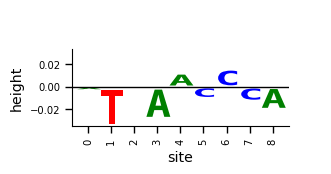

In [65]:
plot_tensor = window_contribution_instances[0, ...]
y_max = plot_tensor.abs().sum(dim=0).max()
matrix_to_dms(plot_tensor, y_max=y_max, heightscale=0.4)
plt.show()

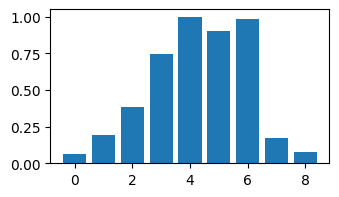

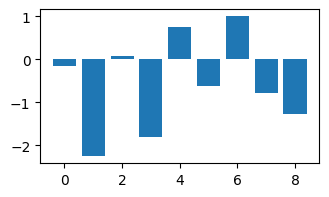

In [66]:
plt.figure(figsize=(motif_length/2.5, 2))
plt.bar(x=range(motif_length), height=position_importances[0])
plt.show()

plt.figure(figsize=(motif_length/2.5, 2))
plt.bar(x=range(motif_length), height=normal_flat_scores[0, ...])
plt.show()

158 167


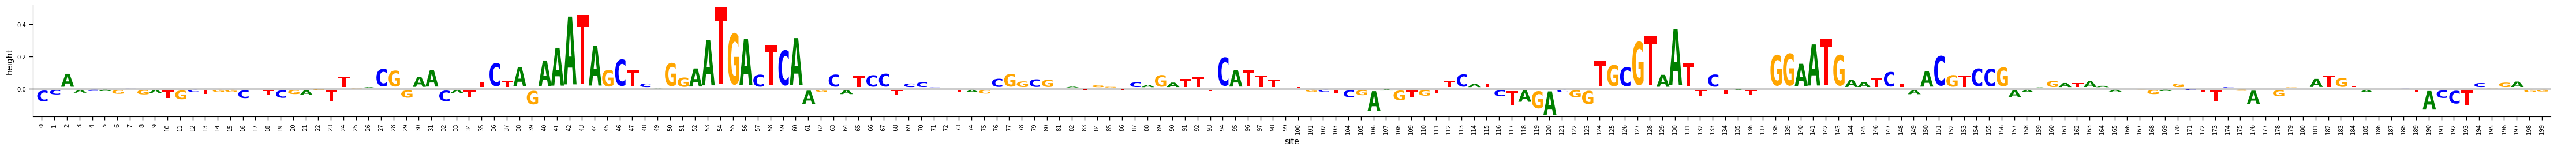

40 49


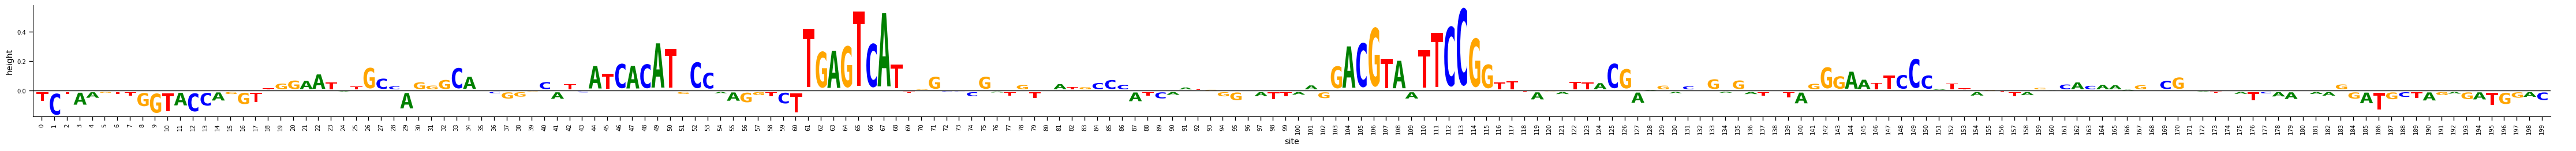

65 74


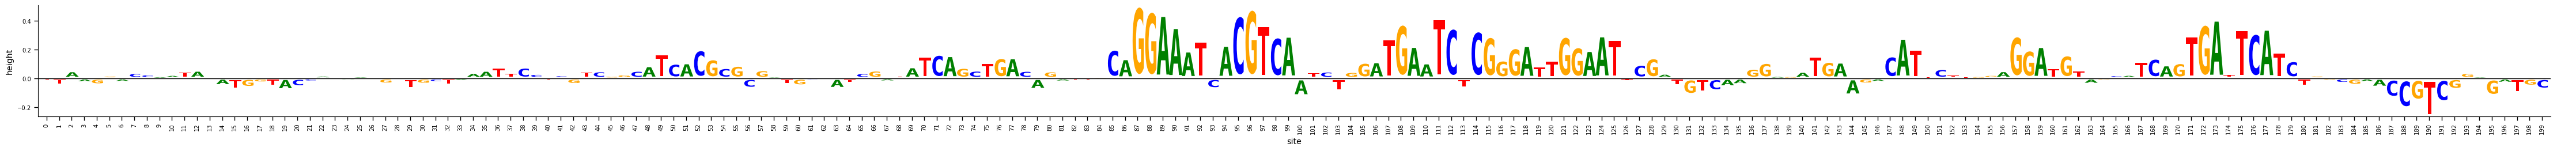

1 10


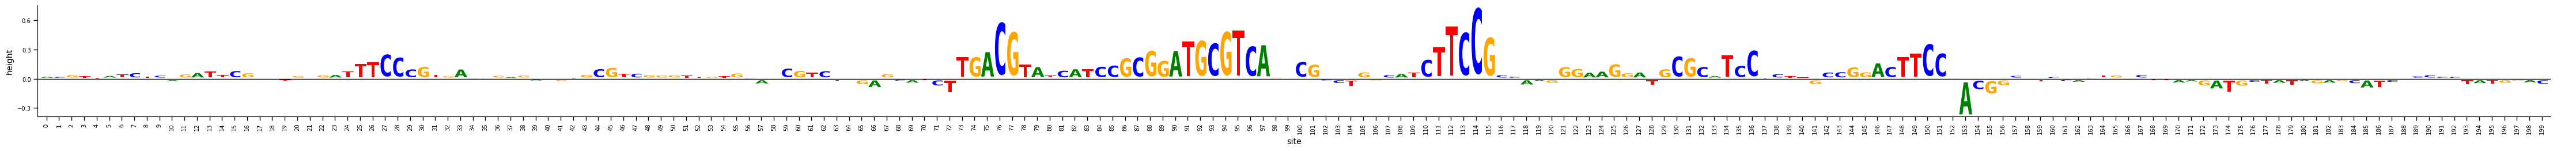

31 40


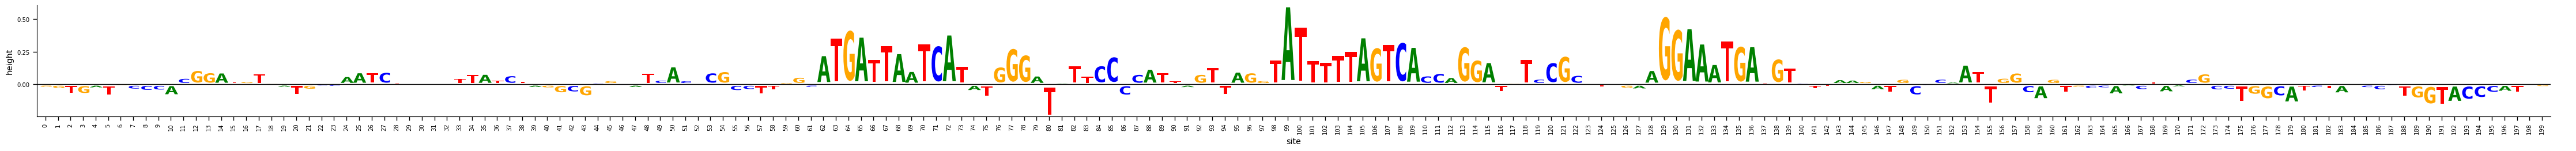

67 76


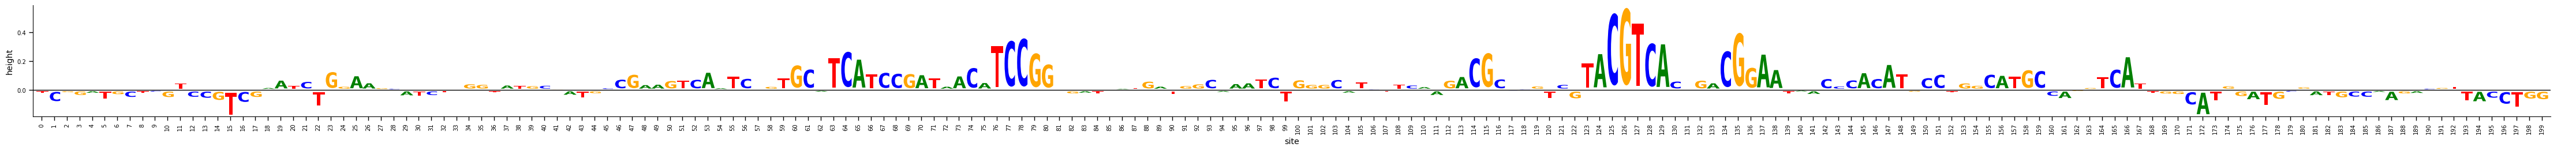

31 40


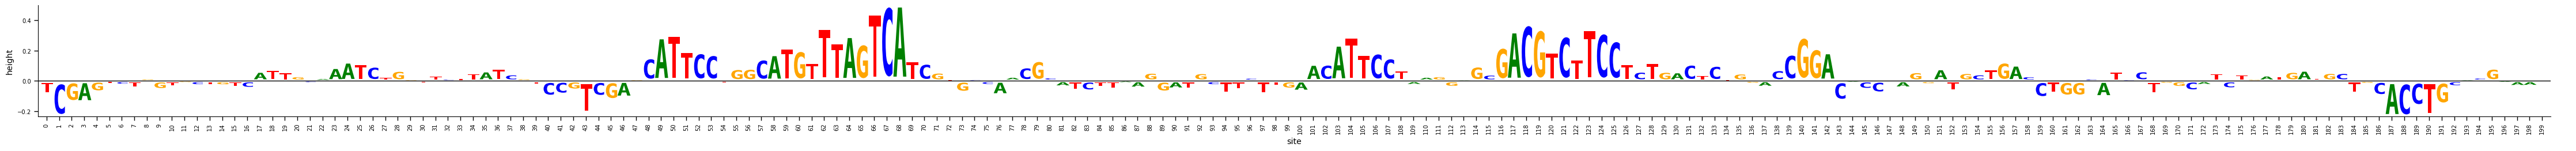

133 142


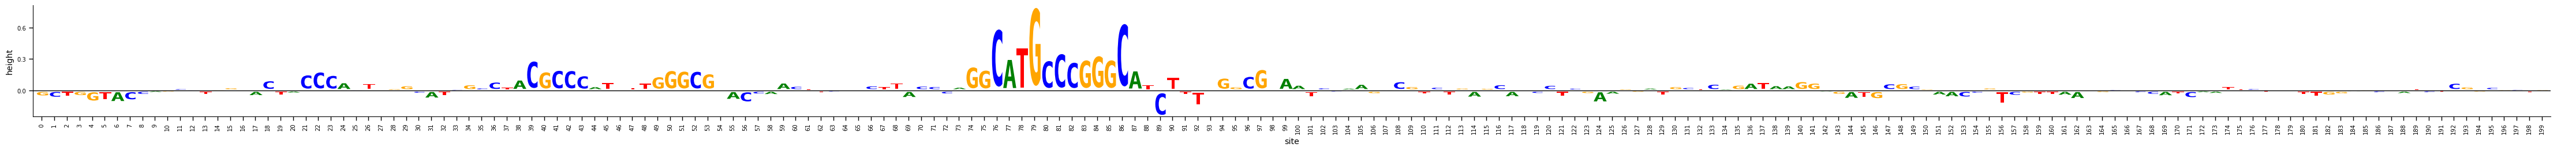

26 35


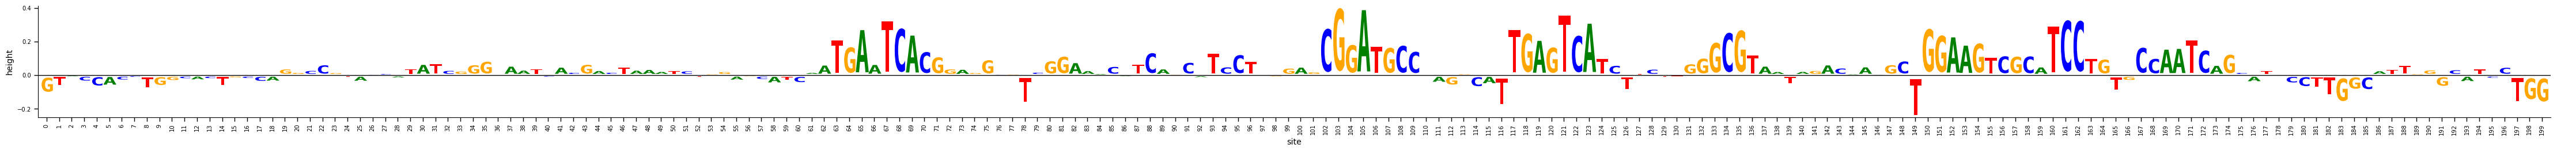

23 32


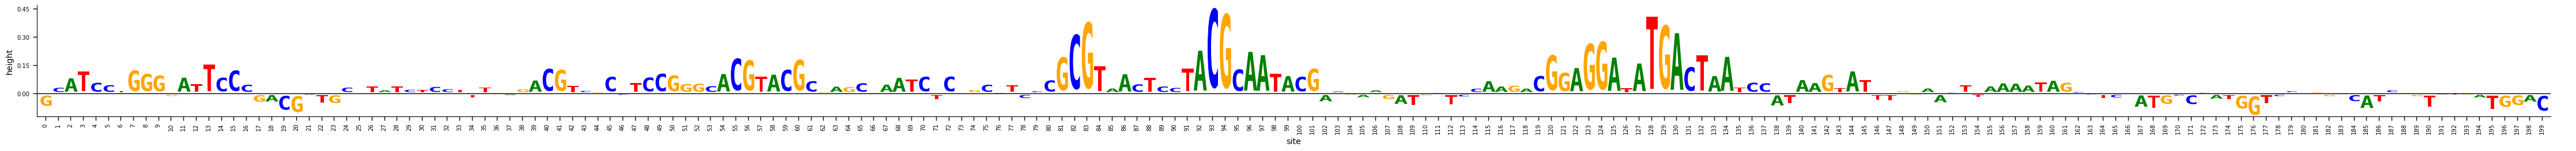

75 84


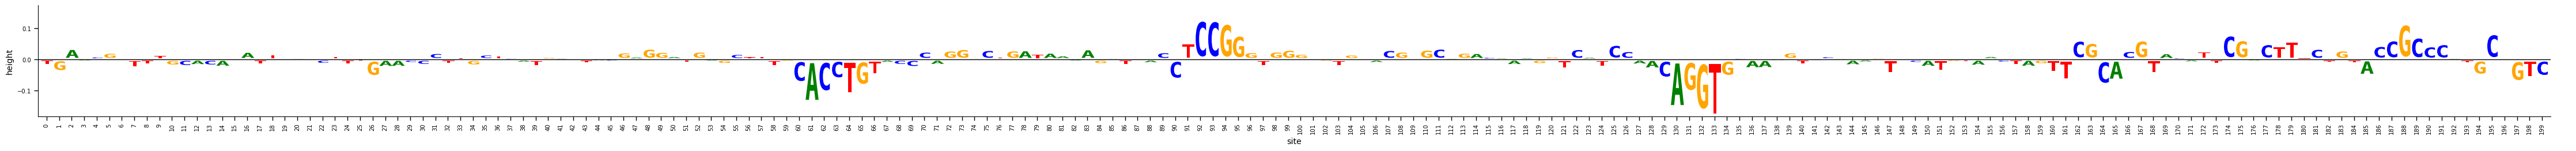

40 49


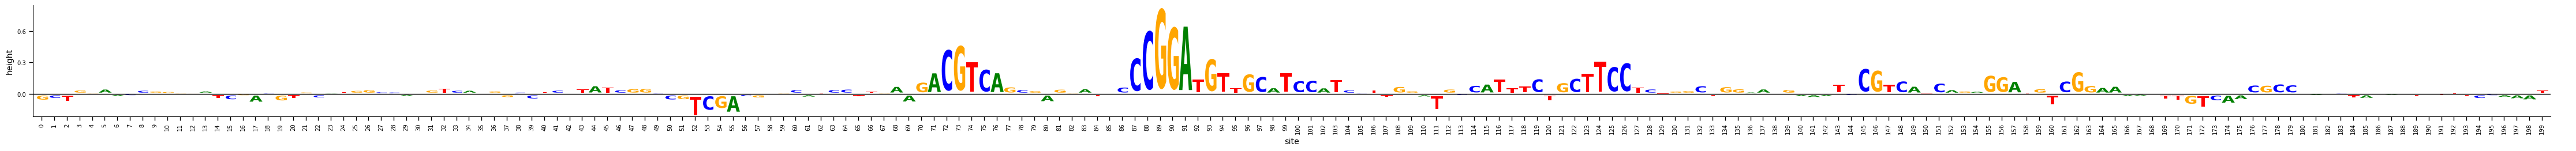

159 168


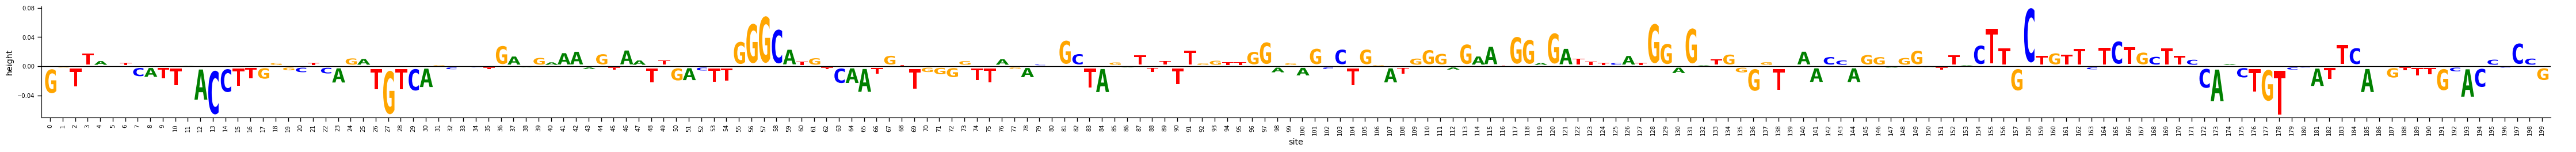

140 149


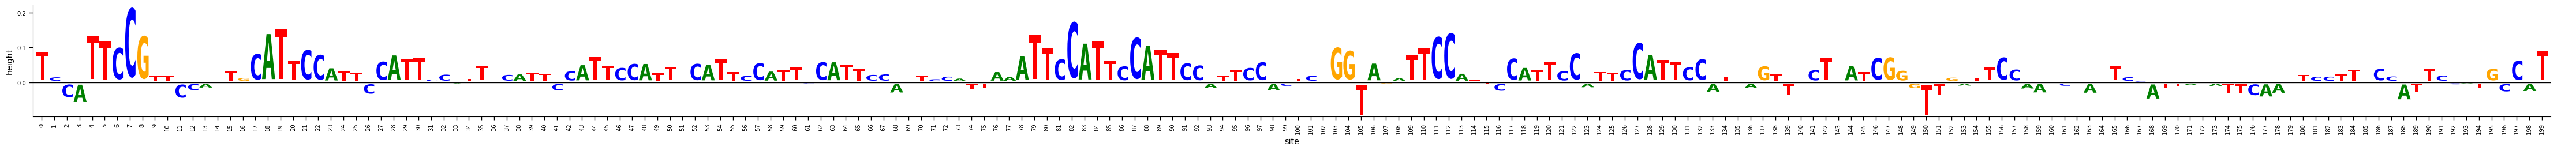

In [47]:
for k in range(14):
    seq_idx = motif_passing_seqs[cell_idx][k]
    start = motif_passing_starts[cell_idx][k]
    end = motif_passing_ends[cell_idx][k]
    rc_flags = motif_passing_rc_flags[cell_idx][k]

    print(start.item(), end.item())
    seq_contribution = all_contributions[cell_idx, seq_idx, ...]
    y_max = seq_contribution.abs().sum(dim=0).max()
    matrix_to_dms(seq_contribution, y_max=y_max, heightscale=1)
    plt.show()

In [157]:
unique_seq_list = []
for motif_seq_list in all_motif_passing_seqs:
    for seq_list in motif_seq_list:
        unique_seq_list += torch.unique(seq_list).tolist()
unique_seq_list = list(set(unique_seq_list))
print(len(unique_seq_list))

67516


In [209]:
coda_library_df[~coda_library_df.index.isin(unique_seq_list)]

,ID,sequence,project,method,round,K562_signal,HepG2_signal,SKNSH_signal,K562_lfcSE,HepG2_lfcSE,SKNSH_lfcSE,K562_ctrl_mean,HepG2_ctrl_mean,SKNSH_ctrl_mean,K562_exp_mean,HepG2_exp_mean,SKNSH_exp_mean,K562_pred,HepG2_pred,SKNSH_pred,K562_pred_aggreg,HepG2_pred_aggreg,SKNSH_pred_aggreg,pred_max_cell,signal_max_cell,target_cell,target_cell_lfc,max_non_target_cell,max_non_target_lfc,min_non_target_cell,min_non_target_lfc,mean_non_target_lfc,OverMean,OverMax,contrib_K562,contrib_HepG2,contrib_SKNSH
101,20211207_63610__124703__271::sa__hepg2__0,GTTCAATCTGAGCGTATGCGGGTGTACACCTGCCAGTCCGTCGAGT...,BODA:hepg2,sa,0,-0.621748,-0.196409,-1.497025,0.211987,0.231402,0.343427,925.012306,925.012306,925.012306,599.690355,807.288786,327.869713,-1.390516,7.738133,-1.447189,-1.294710,6.152595,-1.433631,hepg2,hepg2,hepg2,-0.196409,k562,-0.621748,sknsh,-1.497025,-1.059386,0.862978,0.425339,[-1.04170786e-02 4.86573158e-03 -1.56728048e-...,[-5.86292185e-02 1.42540485e-02 -1.60905272e-...,[-0.05405876 -0.021851376 -0.025494648 ...
114,20211207_63610__124703__303::sa__hepg2__0,TGTGGTTTCTGGAAGGTACTGATTGTAAATCACTGCAAGCCTCTCA...,BODA:hepg2,sa,0,0.853839,3.595662,0.272996,1.395215,0.554270,2.542321,9.225190,9.225190,9.225190,16.385228,112.859114,11.141840,-1.121278,6.010777,-1.069463,-0.991670,5.533018,-1.059278,hepg2,hepg2,hepg2,3.595662,k562,0.853839,sknsh,0.272996,0.563417,3.032245,2.741823,[ 0.033695057 0.004798844 0.0053080763 ...,[ 6.96000503e-03 8.79284646e-03 -4.66945209e-...,[-2.75631398e-02 -3.33145894e-02 -2.11884994e-...
169,20211207_63610__124703__451::sa__hepg2__0,AGATCAAAGATAGCTATTGAAGCGTGCTCTTGCGCAACCTTTGCAG...,BODA:hepg2,sa,0,-0.613862,3.384579,-1.346498,0.220142,0.339725,0.249653,660.833530,660.833530,660.833530,429.770434,6902.053972,259.769297,-0.714857,6.137222,-0.719761,-0.739574,4.355067,-0.653403,hepg2,hepg2,hepg2,3.384579,k562,-0.613862,sknsh,-1.346498,-0.980180,4.364759,3.998441,[ 0.001375146 -0.013613503 0.017396275 ...,[ 8.54214653e-02 1.78281397e-01 1.69694141e-...,[ 4.54111733e-02 -6.59567537e-03 3.53706926e-...
199,20211207_63610__124703__517::sa__hepg2__0,TGATGCTGTCTACGAACAGGTACGGTCGTTCGGCGATAAGACTGAG...,BODA:hepg2,sa,0,-0.188158,2.675379,0.190443,0.170154,0.276348,0.156271,1219.485061,1219.485061,1219.485061,1068.041930,7790.301727,1392.107995,-0.692368,6.143187,-0.713303,-0.652782,5.593229,-0.650791,hepg2,hepg2,hepg2,2.675379,sknsh,0.190443,k562,-0.188158,0.001143,2.674237,2.484936,[ 7.48490542e-02 -6.03166372e-02 1.32549470e-...,[ 9.74274427e-02 -9.35474560e-02 1.37192057e-...,[ 0.04363517 -0.027926667 0.06622343 0....
453,20211207_63610__124703__1145::sa__hepg2__0,TACCCTACGGTGGATCTTATCAGAGGTCATACCTTGGACACCTGAA...,BODA:hepg2,sa,0,0.022873,3.540962,-0.143167,0.187453,0.320283,0.123006,1666.628640,1666.628640,1666.628640,1693.898689,19398.636113,1509.000899,-0.722824,6.408225,-0.633917,-0.546744,6.516104,-0.528689,hepg2,hepg2,hepg2,3.540962,k562,0.022873,sknsh,-0.143167,-0.060147,3.601109,3.518089,[ 1.79675892e-02 6.28704997e-03 -5.23000024e-...,[ 1.47083737e-02 2.81495638e-02 -5.73284775e-...,[-3.17014679e-02 1.73789430e-02 -4.78719622e-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74873,chr22:49386550-49386750,TACTGACTCATGTCTAAGAGATTTTCTGTGTGCACAGTCATACTGA...,BODA:genomic,gs,0,0.425816,2.918808,5.704309,0.197420,0.232612,0.550279,1314.098705,1314.098705,1314.098705,1764.590233,9937.575102,68516.910611,2.598728,2.930914,6.296068,3.348794,4.083991,6.989733,sknsh,sknsh,sknsh,5.704309,hepg2,2.918808,k562,0.425816,1.672312,4.031996,2.785500,[ 4.73833680e-02 1.35688307e-02 5.08464873e-...,[ 1.06027508e-02 2.39140578e-02 -2.11197212e-...,[ 1.98782682e-02 1.75248291e-02 1.13514503e-...
74914,chr4:189268050-189268250,TGAGATTGCACAGAGGAGTGGACGATGGGATTGTACAGAGGAGTGG...,BODA:genomic,gs,0,3.718838,3.465629,6.288769,0.227284,0.337549,0.155765,73.527503,73.527503,73.527503,970.403696,811.487389,5726.432913,2.404404,2.883948,6.239207,

In [158]:
all_df_to_concat = []
for motif_idx, motif_name in enumerate(custom_motif_names):
    for cell_idx, cell_type in enumerate(cell_types):
        df_to_append = pd.DataFrame(columns=['motif_id', 'motif_alt_id', 'sequence_name', 'start', 'stop', 'strand', 'cell_type'])
        motif_passing_seqs = all_motif_passing_seqs[motif_idx][cell_idx].tolist()
        motif_passing_rc_flags = all_motif_passing_rc_flags[motif_idx][cell_idx].tolist()
        motif_passing_starts = all_motif_passing_starts[motif_idx][cell_idx].tolist()
        motif_passing_ends = all_motif_passing_ends[motif_idx][cell_idx].tolist()

        seq_ids = coda_library_df.iloc[motif_passing_seqs]['ID'].tolist()

        df_to_append['sequence_name'] = seq_ids
        df_to_append['start'] = motif_passing_starts
        df_to_append['stop'] = motif_passing_ends
        df_to_append['strand'] = motif_passing_rc_flags
        df_to_append['cell_type'] = cell_type
        df_to_append['motif_id'] = motif_ids[motif_idx]
        df_to_append['motif_alt_id'] = motif_name

        all_df_to_concat.append(df_to_append)

contribution_fimo_df = pd.concat(all_df_to_concat).reset_index(drop=True)

contribution_fimo_df['start'] = contribution_fimo_df['start'].astype(int)
contribution_fimo_df['stop'] = contribution_fimo_df['stop'].astype(int)
contribution_fimo_df['strand'] = contribution_fimo_df['strand'].astype(int)

In [159]:
seq_ids = ['20211212_75659__621411__391::fsp__sknsh__0', #N5 #BODA_SKNSH_Test1
                '20211206_24503__33072627__1223::al__hepg2__0', #L2

                '20211212_45907__313665__213::fsp__hepg2__0', #BODA_HEPG2_Test1
                '20211212_61436__944763__262::fsp__hepg2__0', #BODA_HEPG2_Test2
                '20211207_212124__46481152__2927::al__sknsh__0', #N3 #BODA_SKNSH_Test2
                '20211207_152258__777391__191::sa__sknsh__0', #N2
                '20211207_212124__46481152__3404::al__sknsh__0', #N4
                '20211206_24503__33072627__1816::al__hepg2__0', #L3
                '20211207_100944__255626__132::sa__hepg2__0', #L4

                '20211207_63610__124703__1517::sa__hepg2__0', #?
                '20211207_212124__46481152__3727::al__sknsh__0', #L?

                '20211212_55149__346635__38::fsp__hepg2__0',
                '20211212_52639__969454__182::fsp__hepg2__0',
                '20211212_12620__229779__1223::fsp__hepg2__0',
                '20211212_55149__346635__486::fsp__hepg2__0',
                '20211212_55149__346635__150::fsp__hepg2__0',
                '20211212_52639__969454__185::fsp__hepg2__0',
                '20211212_12620__229779__1181::fsp__hepg2__0',
                '20211212_12620__229779__56::fsp__hepg2__0',
                ]

intersection_threshold = 200
cmap = plt.get_cmap('rainbow', len(motif_ids))

color_dict = dict(zip(2 * motif_ids, 2*[cmap(i) for i in range(len(motif_ids))]))

for order_idx, seq_id in enumerate(seq_ids):

    seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

    for cell_idx, cell_type in enumerate(cell_types):
        seq_scan_df = contribution_fimo_df[(contribution_fimo_df['sequence_name'] == seq_id) & (contribution_fimo_df['cell_type'] == cell_type)]

        seq_contributions = all_contributions[cell_idx, seq_idx, ...]
        y_max = seq_contributions.max()

        find_motif_names  = []
        motifs_start_ends = []
        orientations      = []
        cover_set         = set()
        num_hits = len(seq_scan_df)
        for i in range(num_hits):
            hit_row = seq_scan_df.iloc[i]
            m_start, m_end = hit_row['start'], hit_row['stop']
            motif_range = set(np.arange(m_start, m_end))
            motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
            pos_contribution = motif_contributions.max()
            neg_contribution = motif_contributions.min()
            contribution_condition = True #(pos_contribution > 0.06) or (neg_contribution < -0.02)
            if (len(cover_set & motif_range) <= intersection_threshold) and contribution_condition:
                find_motif_names.append(hit_row['motif_id'])
                motifs_start_ends.append((m_start, m_end))
                orientations.append(hit_row['strand'])
                cover_set = cover_set | motif_range
            find_motif_short_names = [name + ' ' + str(strand) for name, strand in zip(find_motif_names, orientations)]

        matrix_plot = seq_contributions.clone()
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            heightscale=1.3, fontaspect=0.55)
        for idx, motif_name in enumerate(find_motif_names):
            try:
                color = color_dict[motif_name]
            except:
                color = color_dict[f'{motif_name}b']
            plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

            text = f'{find_motif_short_names[idx]}'#' ({motif_pct_select[idx]}%)'
            x = motifs_start_ends[idx][0]
            y = contrib_min_maxs[idx][1] + 0.05
            plt.text(x, y, text, fontsize=16, rotation=90)
        plt.show()

    print()

Output hidden; open in https://colab.research.google.com to view.

In [116]:
seq_contributions.shape

torch.Size([4, 200])

In [117]:
m_start, m_end

(0.0, 9.0)

# Trying Pearson sweeps

In [65]:
cell_idx = 0
cell_hyp_contributions = all_hyp_contributions[cell_idx, ...]

motif_legth_set = np.unique([icm.shape[-1] for icm in fwd_motif_hyp_scores])
window_len = motif_legth_set[0]

all_window_hyp_contribtutions = [cell_hyp_contributions[..., torch.arange(position, position + window_len)] for position in range(200 - window_len)]
all_window_hyp_contribtutions = torch.stack(all_window_hyp_contribtutions, dim=1)

all_window_hyp_contribtutions = all_window_hyp_contribtutions.flatten(0, 1)

In [81]:
max_scores = torch.amax(all_window_hyp_contribtutions.abs(), dim=(1,2)).reshape(-1, 1, 1)

In [83]:
all_window_hyp_contribtutions_normal = all_window_hyp_contribtutions / max_scores

In [99]:
def pearson_correlation_windows(tensor, filter):
    filter_len = filter.shape[-1]
    # Reshape the filter to match the window shape
    filter = filter.view(1, 1, 4, filter_len)

    # Reshape the tensor to have windows as separate dimensions
    tensor = tensor.view(-1, 1, 4, filter_len)

    # Normalize input and filter to zero mean and unit variance
    tensor_normalized = (tensor - tensor.mean(dim=-1, keepdim=True)) / tensor.std(dim=-1, keepdim=True)
    filter_normalized = (filter - filter.mean()) / filter.std()

    # Compute element-wise product
    elementwise_product = tensor_normalized * filter_normalized

    # Compute Pearson correlation
    pearson_corr = F.avg_pool2d(elementwise_product, kernel_size=(4, filter_len), stride=1)

    return pearson_corr.squeeze(1).squeeze(2)


In [90]:
# def pearson_correlation_windows(tensor, filter):
#     window_shape = filter.shape

#     # Reshape the filter to match the window shape
#     filter = filter.view(1, 1, *window_shape)

#     # Reshape the tensor to have windows as separate dimensions
#     tensor_shape = tensor.shape
#     tensor = tensor.view(tensor_shape[0], 1, *window_shape)

#     # Normalize input and filter to zero mean and unit variance
#     tensor_normalized = (tensor - tensor.mean(dim=-1, keepdim=True)) / tensor.std(dim=-1, keepdim=True)
#     filter_normalized = (filter - filter.mean()) / filter.std()

#     # Compute element-wise product
#     elementwise_product = tensor_normalized * filter_normalized

#     # Compute Pearson correlation
#     pearson_corr = F.avg_pool2d(elementwise_product, kernel_size=window_shape[1:], stride=1)

#     return pearson_corr.squeeze(1).squeeze(2)

In [161]:
motif_ids.index('neg_core_0')

28

In [164]:
%%time
motif_idx = 28
cell_idx = 2

cell_hyp_contributions = all_hyp_contributions[cell_idx, ...]

fwd_filter = fwd_motif_hyp_scores[motif_idx]
fwd_filter = fwd_filter / fwd_filter.abs().max()

rev_filter = rev_motif_hyp_scores[motif_idx]
rev_filter = rev_filter / rev_filter.abs().max()

window_len = fwd_filter.shape[-1]

all_window_hyp_contribtutions = [cell_hyp_contributions[..., torch.arange(position, position + window_len)] for position in range(200 - window_len)]
all_window_hyp_contribtutions = torch.stack(all_window_hyp_contribtutions, dim=1)

all_window_hyp_contribtutions = all_window_hyp_contribtutions.flatten(0, 1)
max_scores = torch.amax(all_window_hyp_contribtutions.abs(), dim=(1,2)).reshape(-1, 1, 1)
all_window_hyp_contribtutions_normal = all_window_hyp_contribtutions / max_scores

fwd_motif_pearsons = pearson_correlation_windows(all_window_hyp_contribtutions_normal, fwd_filter)
fwd_motif_pearsons = fwd_motif_pearsons.unflatten(0, (75000, 200 - window_len))

rev_motif_pearsons = pearson_correlation_windows(all_window_hyp_contribtutions_normal, rev_filter)
rev_motif_pearsons = rev_motif_pearsons.unflatten(0, (75000, 200 - window_len))

CPU times: user 1min 35s, sys: 11.1 s, total: 1min 47s
Wall time: 27.8 s


In [165]:
print((fwd_motif_pearsons > 0.75).sum().item() + (rev_motif_pearsons > 0.75).sum().item())

9


In [148]:
torch.where((motif_pearsons > 0.7))

(tensor([  458,   491,   554,  ..., 74983, 74983, 74983]),
 tensor([145,  33, 159,  ...,  17,  62,  97]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [141]:
motif_pearsons.mean(), motif_pearsons.std()

(tensor(-0.0004), tensor(0.1333))

In [149]:
print((motif_pearsons > 0.75).sum().item())

752


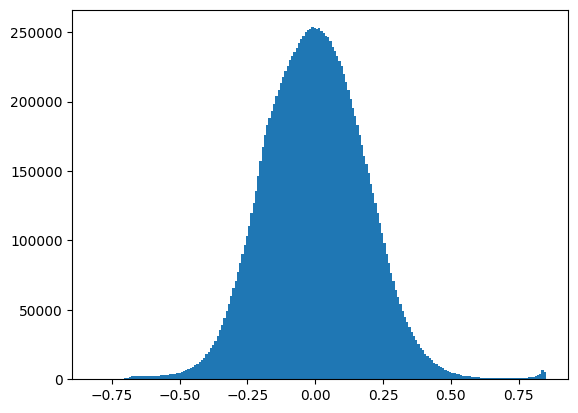

In [109]:
plt.hist(motif_pearsons[:, 0].tolist(), bins=200)
plt.show()

In [110]:
(motif_pearsons > 0.6).sum()

tensor(45688)

In [113]:
motif_pearsons = motif_pearsons.unflatten(0, (75000, 200 - window_len))

torch.Size([75000, 191, 1])